# GOSS (Garbage Optical Sorting System)

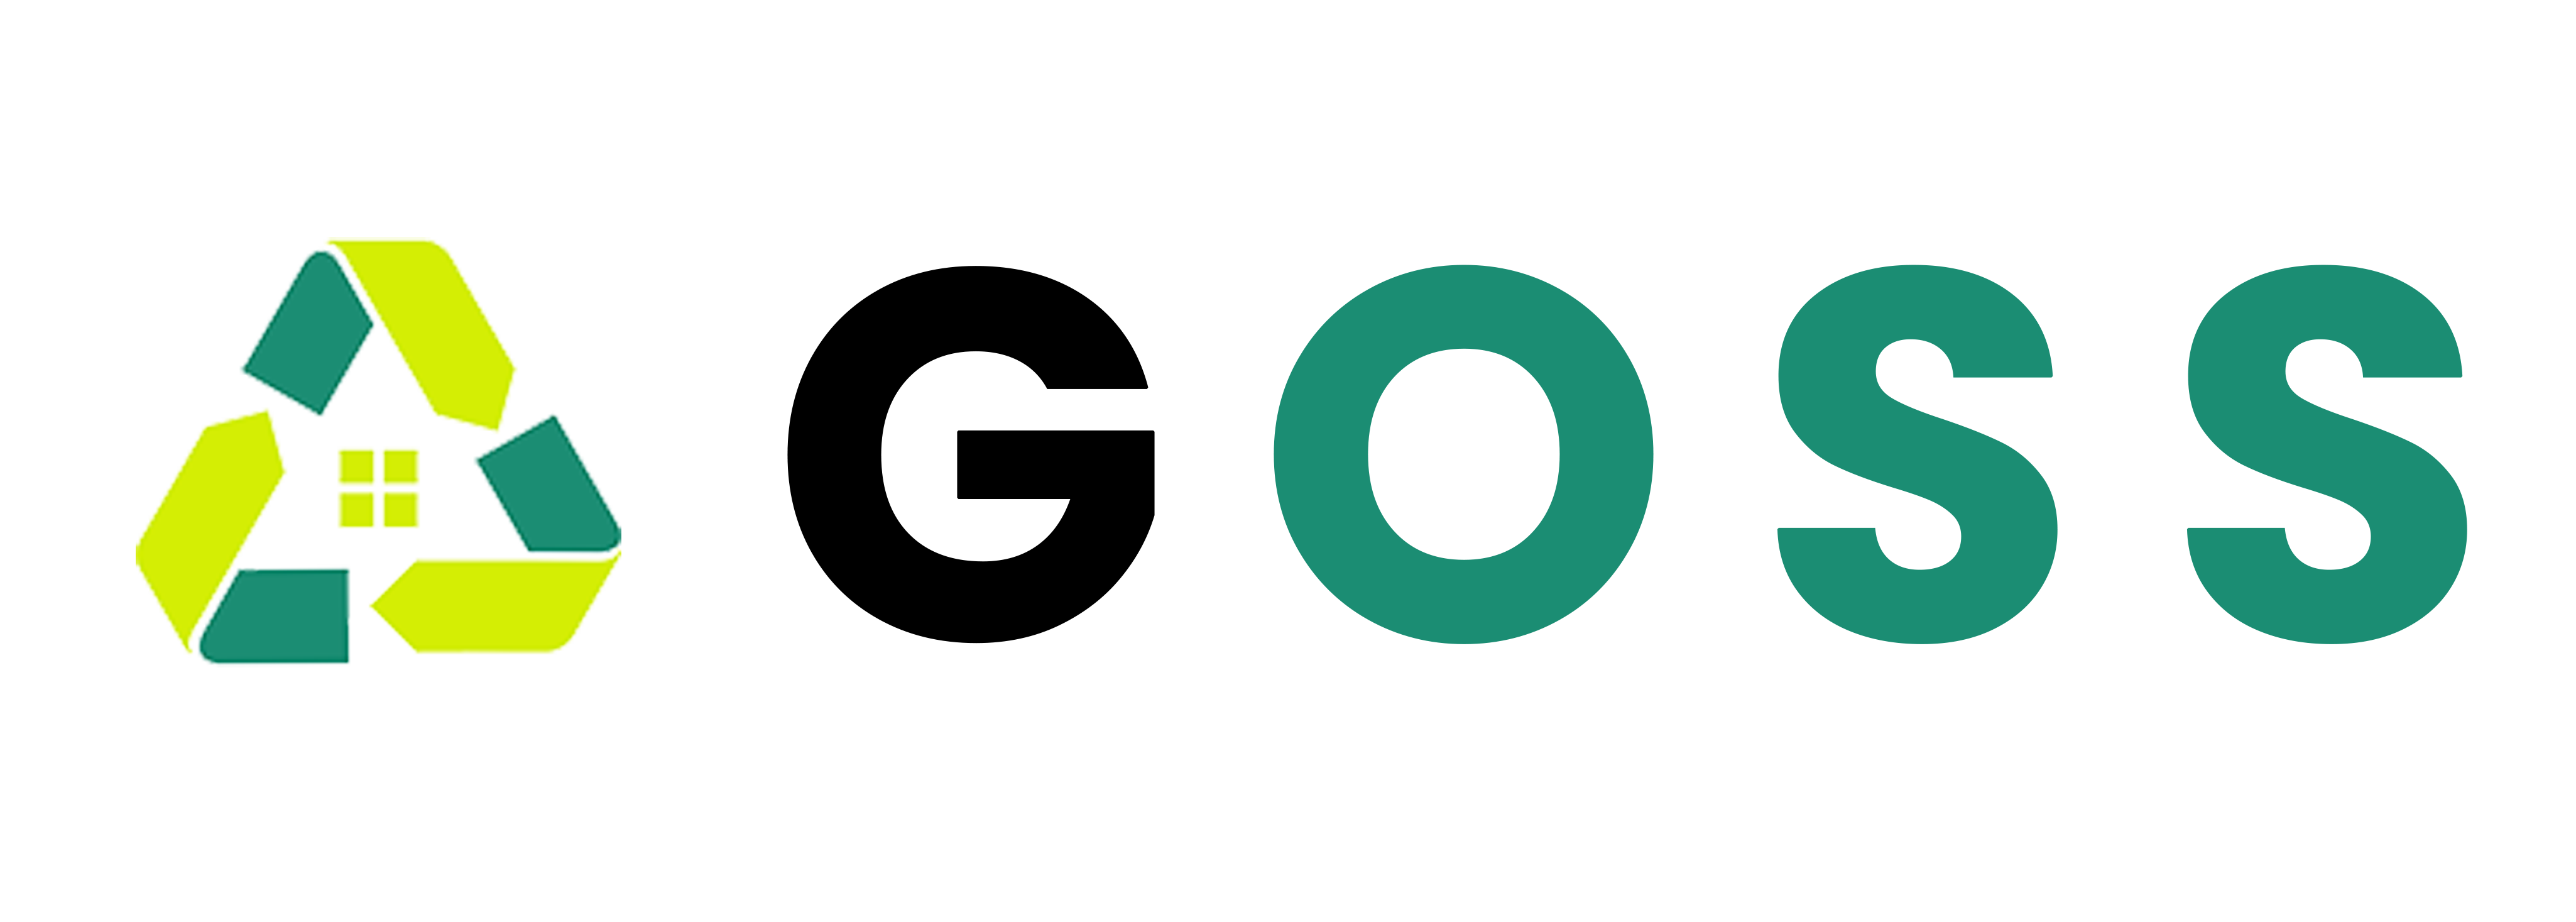

# Team Members : 
    Jay Shende
    Siddhant Patil
    Adarsh Jena
    Sudhanshu Nerkar

# Problem Statement :
Recycling facilities often have a large volume of waste to sort through, and manually sorting through this waste can be time-consuming and prone to errors. The problem is to develop a machine learning model that can accurately detect and classify different types of waste in images, such as plastic, paper, metal, etc. The goal is to create a model that can improve sorting efficiency and reduce the amount of waste sent to landfills.

# Survey & Research :
Recycling contamination occurs when waste is incorrectly disposed of — like recycling a pizza box with oil on it (compost). Or when waste is correctly disposed of but incorrectly prepared — like recycling unrinsed jam jars. Contamination is a huge problem in the recycling industry that can be mitigated with automated waste sorting. This is an application of optical sorting system.

Official numbers say that we generate more than 62 million tonnes of municipal solid waste but only 43 million tonnes is collected. Of the 43 million tonnes collected, municipalities are forced to dump more than 31 million in landfills due to its mixed nature.

In [1]:
import numpy as np
import cv2
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Conv2D, Flatten, MaxPooling2D,Dense,Dropout,SpatialDropout2D
from keras.models  import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import random,os,glob
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Dataset Input

In [2]:
dir_path = '../input/garbage classification/Garbage classification'

In [3]:
img_list = glob.glob(os.path.join(dir_path, '*/*.jpg'))

In [4]:
len(img_list)

2527

# Image Augmentation

In [5]:
train=ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         validation_split=0.1,
                         rescale=1./255,
                         shear_range = 0.1,
                         zoom_range = 0.1,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,)

test=ImageDataGenerator(rescale=1/255,
                        validation_split=0.1)

train_generator=train.flow_from_directory(dir_path,
                                          target_size=(300,300),
                                          batch_size=32,
                                          class_mode='categorical',
                                          subset='training')

test_generator=test.flow_from_directory(dir_path,
                                        target_size=(300,300),
                                        batch_size=32,
                                        class_mode='categorical',
                                        subset='validation')

labels = (train_generator.class_indices)
print(labels)

labels = dict((v,k) for k,v in labels.items())
print(labels)

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.
{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


In [6]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((32, 300, 300, 3), (32, 6))

### Writing the labels file

In [7]:
print (train_generator.class_indices)

Labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(Labels)


{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


# Building CNN & Saving keras model

In [8]:
model=Sequential()
#Convolution blocks

model.add(Conv2D(32,(3,3), padding='same',input_shape=(300,300,3),activation='relu'))
model.add(MaxPooling2D(pool_size=2)) 
#model.add(SpatialDropout2D(0.5)) # No accuracy

model.add(Conv2D(64,(3,3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2)) 
#model.add(SpatialDropout2D(0.5))

model.add(Conv2D(32,(3,3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2)) 

#Classification layers
model.add(Flatten())

model.add(Dense(64,activation='relu'))
#model.add(SpatialDropout2D(0.5))
model.add(Dropout(0.2))
model.add(Dense(32,activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(6,activation='softmax'))

filepath="trained_model.h5"
checkpoint1 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint1]



# Summarizing our model

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 300, 300, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 32)        18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 43808)             0         
__________

### Compiling Model using categorical cross entropy loss function & Adam Optimizer

In [10]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc']) # RMS PROP - No accuracy

#es=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)


# Let's Train

In [11]:
history = model.fit_generator(train_generator,
                              epochs=100,
                              steps_per_epoch=2276//32,
                              validation_data=test_generator,
                              validation_steps=251//32,
                              workers = 4,
                              callbacks=callbacks_list) 
#41 epoch - 75% #73- 76.9%
#78 epoch - 80%

Epoch 1/100
71/71 [==============================] - 43s 599ms/step - loss: 1.7782 - acc: 0.2073 - val_loss: 1.7156 - val_acc: 0.2098

Epoch 00001: val_acc improved from -inf to 0.20982, saving model to trained_model.h5
Epoch 2/100
71/71 [==============================] - 34s 485ms/step - loss: 1.6716 - acc: 0.2790 - val_loss: 1.5572 - val_acc: 0.2831

Epoch 00002: val_acc improved from 0.20982 to 0.28311, saving model to trained_model.h5
Epoch 3/100
71/71 [==============================] - 34s 485ms/step - loss: 1.5567 - acc: 0.3424 - val_loss: 1.4587 - val_acc: 0.3607

Epoch 00003: val_acc improved from 0.28311 to 0.36073, saving model to trained_model.h5
Epoch 4/100
71/71 [==============================] - 35s 491ms/step - loss: 1.4681 - acc: 0.3896 - val_loss: 1.2861 - val_acc: 0.5068

Epoch 00004: val_acc improved from 0.36073 to 0.50685, saving model to trained_model.h5
Epoch 5/100
71/71 [==============================] - 35s 491ms/step - loss: 1.4081 - acc: 0.4406 - val_loss: 1.

# Testing PREDICTION 
##### Note: Path is of training dataset (pl. don't mind)

Maximum Probability:  0.9989919
Classified: plastic


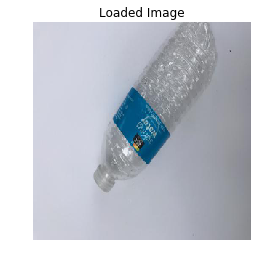

In [12]:
from keras.preprocessing import image

img_path = '../input/garbage classification/Garbage classification/plastic/plastic75.jpg'

img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img, dtype=np.uint8)
img=np.array(img)/255.0

plt.title("Loaded Image")
plt.axis('off')
plt.imshow(img.squeeze())

p=model.predict(img[np.newaxis, ...])

#print("Predicted shape",p.shape)
print("Maximum Probability: ",np.max(p[0], axis=-1))
predicted_class = labels[np.argmax(p[0], axis=-1)]
print("Classified:",predicted_class)




-------------------Individual Probability--------------------------------

CARDBOARD : 0.05 %
GLASS : 0.04 %
METAL : 0.01 %
PAPER : 0.0 %
PLASTIC : 99.9 %
TRASH : 0.0 %


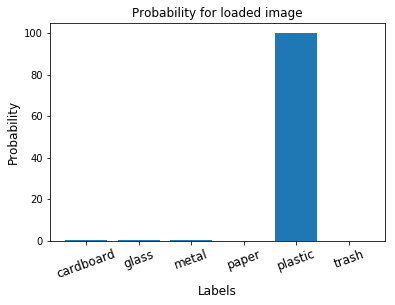

In [13]:
classes=[]
prob=[]
print("\n-------------------Individual Probability--------------------------------\n")

for i,j in enumerate (p[0],0):
    print(labels[i].upper(),':',round(j*100,2),'%')
    classes.append(labels[i])
    prob.append(round(j*100,2))
    
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(classes))
    plt.bar(index, prob)
    plt.xlabel('Labels', fontsize=12)
    plt.ylabel('Probability', fontsize=12)
    plt.xticks(index, classes, fontsize=12, rotation=20)
    plt.title('Probability for loaded image')
    plt.show()
plot_bar_x()

# Accuracy Graph

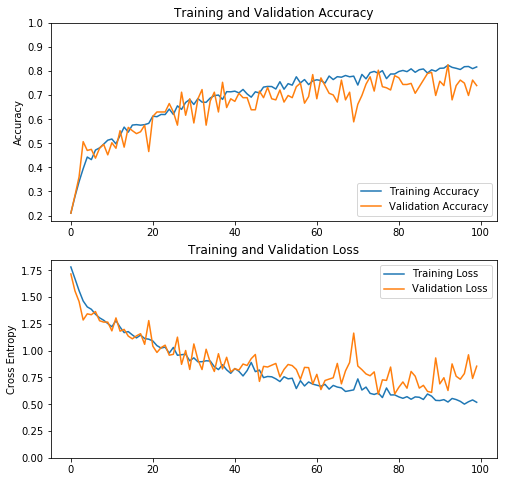

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

# ________________ Graph 1 -------------------------

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# ________________ Graph 2 -------------------------

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

## Converting to TFLite
#### Note: Image Size is 300

In [15]:
import tensorflow as tf
import keras
file = "Garbage.h5"
keras.models.save_model(model,file)
converter = tf.lite.TFLiteConverter.from_keras_model_file(file)
tflite_model=converter.convert()
open("garbage.tflite",'wb').write(tflite_model)

11378540